In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from src import utils, nlp_topic_utils
from bs4 import BeautifulSoup
import itertools

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

import string
from datetime import datetime
from collections import Counter

from src.process_text_variables import contracted_words_dict, stop_words_dict, punc 


[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Wall Street Forum

## EDA - Raw Data

In [2]:
wallstreet = pd.read_csv('data/wallstreet.csv')

In [3]:
total_num_posts_wall = wallstreet.shape[0] 
print('# of Postings: ', total_num_posts_wall)
print('# of Unique Threads : ', len(wallstreet['threadID'].unique()))
print('# of Unique Subforums : ', len(wallstreet['subforum'].unique()))
print('# of Unique Authors : ', len(wallstreet['authorName'].unique()))
print('# of Membership Types : ', len(wallstreet['postAuthorMembership'].unique()))

# of Postings:  45372
# of Unique Threads :  8755
# of Unique Subforums :  40
# of Unique Authors :  5533
# of Membership Types :  8


In [4]:
wall_authors = pd.DataFrame(wallstreet['authorName'].value_counts()).reset_index()
wall_authors.columns = ['author','num_postings']
wall_authors['prcnt_total_posts'] = wall_authors['num_postings'] / total_num_posts_wall
wall_authors.head(10)

,author,num_postings,prcnt_total_posts
0,med3l1n,4889,0.107754
1,6LACK,1500,0.033060
2,leaguemode,1146,0.025258
3,ExpectUS,1113,0.024531
4,PurityRing,1111,0.024486
5,BonesKoopa,476,0.010491
6,Icepapi,446,0.009830
7,code48k,379,0.008353
8,deusxmacina,354,0.007802
9,dabbingtimes,334,0.007361


In [5]:
wall_threads = pd.DataFrame(wallstreet['threadTitle'].value_counts()).reset_index()
wall_threads.columns = ['thread_topic','num_postings']
wall_threads['prcnt_total_posts'] = wall_threads['num_postings'] / total_num_posts_wall
wall_threads.head(10)

,thread_topic,num_postings,prcnt_total_posts
0,GozNym 2.0 Banking Bot (Page 2 of 3),75,0.001653
1,GozNym 2.0 Banking Bot (Page 1 of 3),75,0.001653
2,[Price & Version update] BTC ATM Malware,73,0.001609
3,GozNym 2.0 Banking Bot (Page 3 of 3),56,0.001234
4,Hello,52,0.001146
5,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
6,CASHAPP GUIDE,50,0.001102
7,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102
8,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
9,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102


In [6]:
wall_subforums = pd.DataFrame(wallstreet['subforum'].value_counts()).reset_index()
wall_subforums.columns = ['subforum','num_postings']
wall_subforums['prcnt_total_posts'] = wall_subforums['num_postings'] / total_num_posts_wall
wall_subforums.head(15)

,subforum,num_postings,prcnt_total_posts
0,Fraud,12277,0.270585
1,General Questions,5225,0.115159
2,Carding Stuff,3836,0.084546
3,Services,2973,0.065525
4,Cannabis,2431,0.053579
5,Introductions,2418,0.053293
6,Counterfeits,1727,0.038063
7,Stimulants,1537,0.033876
8,Announcements,1507,0.033214
9,Digital goods,1443,0.031804


In [7]:
wall_joindate = pd.DataFrame(wallstreet['postAuthorJoinDate'].value_counts()).reset_index()
wall_joindate.columns = ['join_date','count']
wall_joindate['prcnt_total_posts'] = wall_joindate['count'] / total_num_posts_wall
wall_joindate.head(10)

,join_date,count,prcnt_total_posts
0,Despacitoland,4889,0.107754
1,G,1500,0.033060
2,2017-11-06,1227,0.027043
3,2018-01-10,1146,0.025258
4,InterWebz,1113,0.024531
5,2017-07-27,524,0.011549
6,2018-03-03,498,0.010976
7,2017-11-09,427,0.009411
8,2018-05-06,415,0.009147
9,2017-10-17,403,0.008882


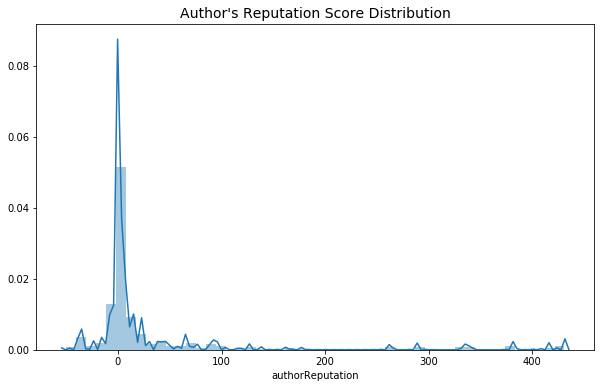

In [8]:
# Max value ~ 5,400.
constraint = 500
reputation = wallstreet[wallstreet['authorReputation'] < constraint]['authorReputation']
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(reputation)
ax.set_title("Author's Reputation Score Distribution", fontsize=14);

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


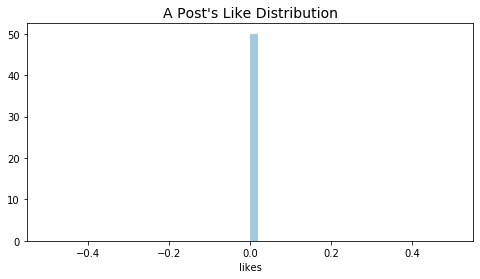

In [9]:
constraint = 100
likes = wallstreet[wallstreet['likes'] < constraint]['likes']
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.distplot(likes)
ax.set_title("A Post's Like Distribution", fontsize=14);

---
# Data Processing / Feature Engineering

In [11]:
wallstreet_v2 = wallstreet.copy()

# Date/time-related features
wallstreet_v2['post_date_time'] = wallstreet_v2['postDate'].apply(utils.fix_postdate_col)
wallstreet_v2['author_join_date'] = wallstreet_v2.apply(lambda x: utils.fix_author_join_date_col(x['postAuthorJoinDate'], x['postAuthorMembership'], x['post_date_time']), axis=1)
wallstreet_v2['post_date'] = wallstreet_v2['post_date_time'].apply(lambda x: x.date())
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['post_date_time'].dt.date - wallstreet_v2['author_join_date'].dt.date
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['num_days_member_when_posted'].dt.days

cols_to_drop = ['URL', 'likes', 'postDate', 'postAuthorJoinDate', 'flatContent']
wallstreet_v2.drop(cols_to_drop, axis=1, inplace=True)

# Text-related features
wallstreet_v2['processed_text'] = wallstreet_v2['contentWithHTMLTag'].apply(lambda x: nlp_topic_utils.process_text(x, contracted_words_dict, punc, stop_words_dict, min_len=2))
wallstreet_v2['parts_of_speech'] = wallstreet_v2['processed_text'].apply(lambda x: nltk.pos_tag(x))
wallstreet_v2['cleaned_post'] = wallstreet_v2['processed_text'].apply(lambda x: ' '.join(x)).astype('str')

# VADER Sentiment Analysis
si_analyzer = SentimentIntensityAnalyzer()
wallstreet_v2['compound_sentiment'] = wallstreet_v2['cleaned_post'].apply(lambda x: si_analyzer.polarity_scores(x)['compound'])

KeyError: 'cleaned_post'

In [14]:
wallstreet_v2['compound_sentiment'] = wallstreet_v2['cleaned_post'].apply(lambda x: si_analyzer.polarity_scores(x)['compound'])

In [15]:
wallstreet_v2.head()

,postID,threadID,threadTitle,subforum,authorName,postAuthorMembership,authorReputation,postSequence,contentWithHTMLTag,post_date_time,author_join_date,post_date,num_days_member_when_posted,processed_text,parts_of_speech,cleaned_post,compound_sentiment
0,6,5,Hi,Introductions,Punka421,New member,-3,1,"<div class=""entry-content"">\n<p>Just thought I...",2016-10-26 13:58:36,2016-10-26,2016-10-26,0.0,"[thought, introduce, new, community, trying, l...","[(thought, VBN), (introduce, VB), (new, JJ), (...",thought introduce new community trying learn m...,0.9287
1,7,5,Hi,Introductions,WSM,Administrator,66,2,"<div class=""entry-content"">\n<p>Hello <img alt...",2016-10-26 14:04:04,2016-10-02,2016-10-26,24.0,"[hello, nice, see, regard]","[(hello, JJ), (nice, JJ), (see, NN), (regard, ...",hello nice see regard,0.4215
2,8,6,WSM Updates - Changelog (Page 1 of 4),Announcements,WSM,Administrator,74,1,"<div class=""entry-content"">\n<p>Hello everyone...",2016-10-26 16:54:27,2016-10-02,2016-10-26,24.0,"[hello, everyone, like, tell, implemented, new...","[(hello, RB), (everyone, NN), (like, IN), (tel...",hello everyone like tell implemented new featu...,0.9825
3,11,5,Hi,Introductions,Estrazy,Banned,0,3,"<div class=""entry-content"">\n<p>Hello Punka! n...",2016-10-27 14:00:16,2016-10-27,2016-10-27,0.0,"[hello, punka, nice, meet, asked, stay, secure...","[(hello, NN), (punka, NN), (nice, JJ), (meet, ...",hello punka nice meet asked stay secure tip ca...,0.9022
4,13,6,WSM Updates - Changelog (Page 1 of 4),Announcements,WSM,Administrator,74,2,"<div class=""entry-content"">\n<h5>Changelog fro...",2016-11-02 15:42:27,2016-10-02,2016-11-02,31.0,"[changelog, wednesday, november, lot, small, i...","[(changelog, NN), (wednesday, JJ), (november, ...",changelog wednesday november lot small issue b...,0.8720


In [16]:
wallstreet_v2.to_csv('data/wallstreet_master.csv', index=False)

---
# EDA using Engineering Features

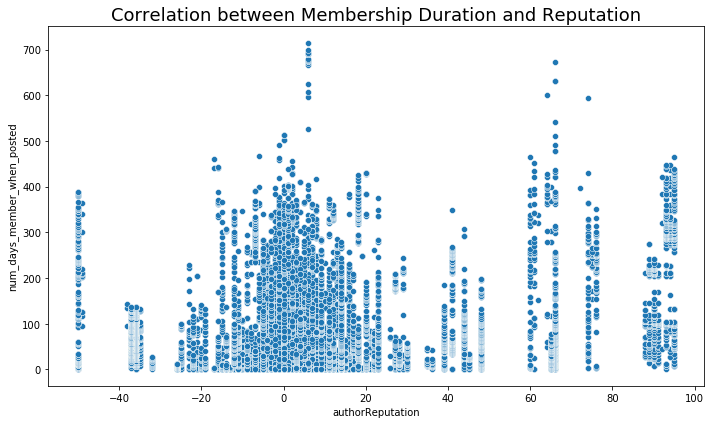

In [27]:
rep_limit = 500
excl_rep_outliers = wallstreet_v2[wallstreet_v2['authorReputation'] < rep_limit]

plt.figure(figsize=(10,6))

sns.scatterplot(y='num_days_member_when_posted', x='authorReputation', data=excl_rep_outliers)
plt.title('Correlation between Membership Duration and Reputation', fontsize=18)
plt.tight_layout();

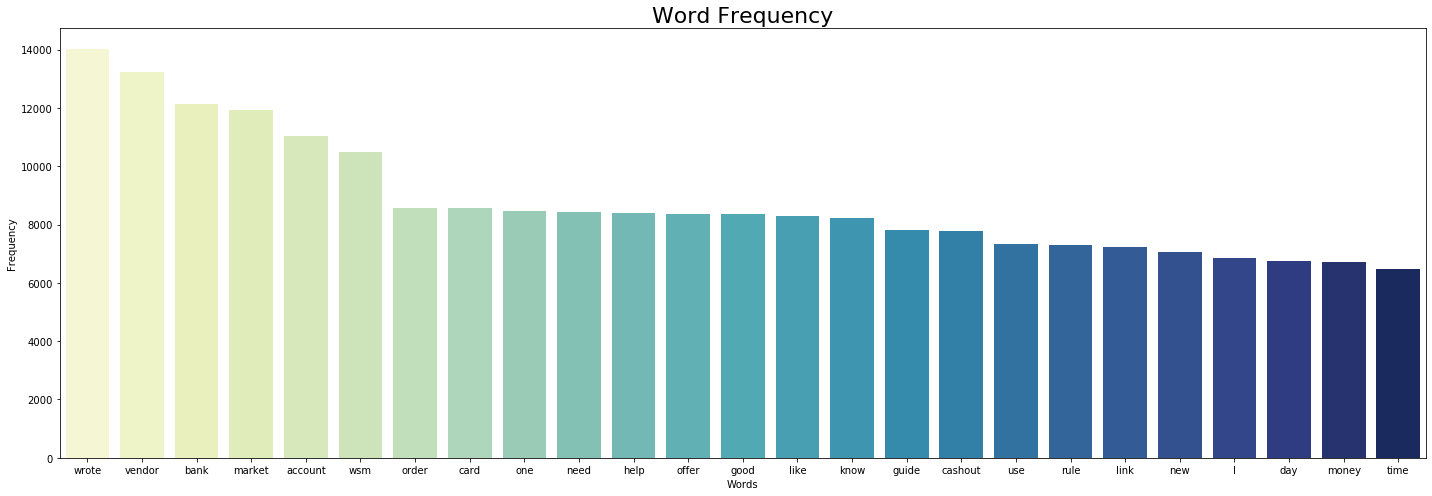

In [20]:
all_words_arr = joined_wordcloud_text.split(' ')
word_freq_df = pd.DataFrame(pd.Series(all_words_arr).value_counts()).reset_index()
word_freq_df.columns = ['word', 'freq'] 

top25_words = word_freq_df[:25]
fig, ax = plt.subplots(figsize=(20,7))

ax = sns.barplot(x='word', y='freq', data=top25_words, palette='YlGnBu')
ax.set_title('Word Frequency', fontsize=22)
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')

plt.tight_layout();

C:\Users\morga\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


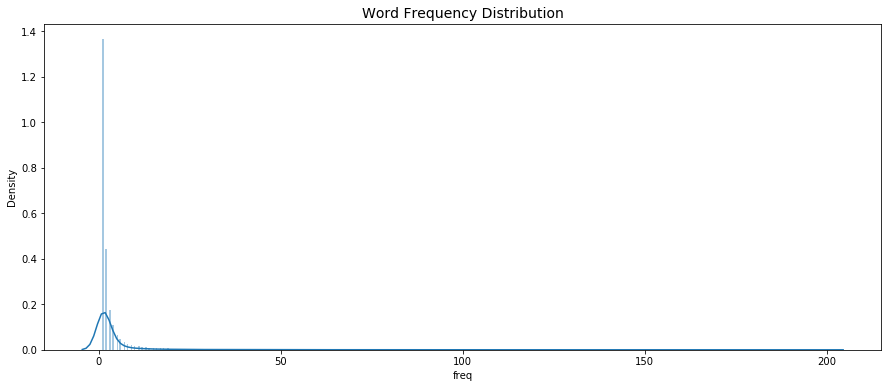

In [21]:
word_freq_dist = word_freq_df[word_freq_df['freq'] < 200]['freq']

word_freq_dist.describe()

fig, ax = plt.subplots(figsize=(15,6))
ax = sns.distplot(word_freq_dist, bins=500)
ax.set_title("Word Frequency Distribution", fontsize=14);

In [1]:
# pos_tag_arr = wallstreet_v2['parts_of_speech']
# pos_dist = {}

# for text in pos_tag_arr:
#     for tag in text:
#         if tag[1] not in pos_dist:
#             pos_dist[tag[1]] = 1
#         else:
#             pos_dist[tag[1]] += 1

# pos_freq_df = pd.DataFrame.from_dict(pos_dist, orient='index').reset_index()
# pos_freq_df.columns = ['pos', 'freq']
# pos_freq_df.sort_values(by=['freq'], axis=1)#, inplace=True)

In [ ]:
# fig, ax = plt.subplots(figsize=(20,7))

# ax = sns.barplot(x='pos', y='feq', data=pos_freq_df, palette='YlGnBu')
# ax.set_title('Parts of Speech Frequency', fontsize=22)
# ax.set_xlabel('Parts of Speech')
# ax.set_ylabel('Frequency')

# plt.tight_layout();